In [41]:
#+.+
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**DATA WRANGLING AND EDA**

In [42]:
def dataset_summary(root_dir):
    stats=[]
    for cls in ['train/real','train/fake']:
        folder=os.path.join(root_dir, cls)
        files=[os.path.join(folder,f) for f in os.listdir(folder)]
        sizes=[]
        for f in files[:200]: #sampling for speed
            img=Image.open(f)
            sizes.append(img.size)
        widths,heights=zip(*sizes)
        stats.append({
            'class':cls,
            'count':len(files),
            'mean_width':np.mean(widths),
            'mean_height':np.mean(heights)
        })
    return pd.DataFrame(stats)

dataset_summary('data')

,class,count,mean_width,mean_height
0,train/real,24000,2362.26,2363.145
1,train/fake,24000,1191.70,1176.245


**Pros:** 

**- Large dataset, good for deep learning** 

**- Balanced classes**


**Cons:** 

**- Very high resolution, may need to resize for training**

**- Real images almost twice as large as fake ones, may need careful preprocessing (resize+normalize)**

In [43]:
base_dir="data"
splits=["train","test"]
labels=["real","fake"]

data=[]

for split in splits: 
    for label in labels: 
        folder=os.path.join(base_dir,split,label)
        for fname in os.listdir(folder): 
            fpath=os.path.join(folder,fname)
            try: 
                with Image.open(fpath) as img: 
                    width,height=img.size
                data.append({
                    'split':split,
                    'label':label,
                    'filepath':fpath,
                    'width':width,
                    'height':height
                })
            except Exception as e: 
                print(f"Skipping {fpath}: {e}")
                
df=pd.DataFrame(data)

print(df.head())
print(df.groupby(['split','label']).size())

/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96012000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site

   split label                   filepath  width  height
0  train  real   data/train/real/9733.jpg   1080    1440
1  train  real  data/train/real/14147.jpg   3275    4094
2  train  real   data/train/real/6400.jpg   1080    1620
3  train  real  data/train/real/13628.jpg    452     570
4  train  real  data/train/real/23933.jpg   1080     720
split  label
test   fake      6000
       real      6000
train  fake     24000
       real     24000
dtype: int64


**We have even classes across the test and train datasets, with a total of 30'000 images in each class across both datasets. Our pre-determined train-test-split is 80/20.**

**We already checked that the dataset is balanced (no oversampling needed), and that there are no corrupted images (handled in loading step). To finish our image integrity check, let's inspect size extremes:**

In [44]:
print(df['width'].describe())
print(df['height'].describe())

count    60000.000000
mean      1729.445250
std       1455.509643
min        224.000000
25%       1024.000000
50%       1080.000000
75%       1792.000000
max      16384.000000
Name: width, dtype: float64
count    60000.000000
mean      1696.257533
std       1375.112757
min        224.000000
25%        928.000000
50%       1024.000000
75%       1667.500000
max      17973.000000
Name: height, dtype: float64


**Most of our images are between ~200 and ~2000 pixels (both in width and height), but there are some extreme outliers (16k-17k pixels). Those outliers may slow down training without providing much extra value. We will need to resize things anyways, so for safety we will probably keep the full data and resize them all to 224x224 pixels.**

**Next, let's add a couple more features for EDA:**

In [45]:
df['aspect_ratio']=df['width']/df['height']
df['area']=df['width']*df['height']
df['log_area']=np.log1p(df['area'])


**Exploring image aspect ratio:**

count    60000.000000
mean         1.078369
std          0.413186
min          0.061425
25%          0.750000
50%          1.000000
75%          1.455400
max         14.222222
Name: aspect_ratio, dtype: float64


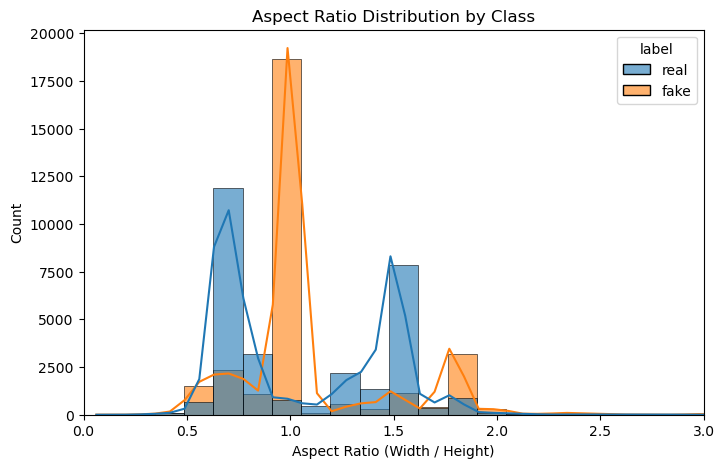

In [46]:
print(df['aspect_ratio'].describe())
plt.figure(figsize=(8,5))
sns.histplot(df,x='aspect_ratio',hue='label',bins=100,kde=True,alpha=0.6)
plt.title("Aspect Ratio Distribution by Class")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Count")
plt.xlim(0,3)
plt.show()

**Most images are roughly square. Despite some extreme outliers, these are likely rare edge cases. This is confirmed by the relatively small standard deviation relative to the full range. Generally, most images cluster around an aspect ratio of 1, so it is reasonable to expect CNN input resizing to handle the data well.**

**Exploring image area:**

count    6.000000e+04
mean     4.578995e+06
std      7.920903e+06
min      5.017600e+04
25%      1.048576e+06
50%      1.188096e+06
75%      3.421636e+06
max      1.610875e+08
Name: area, dtype: float64


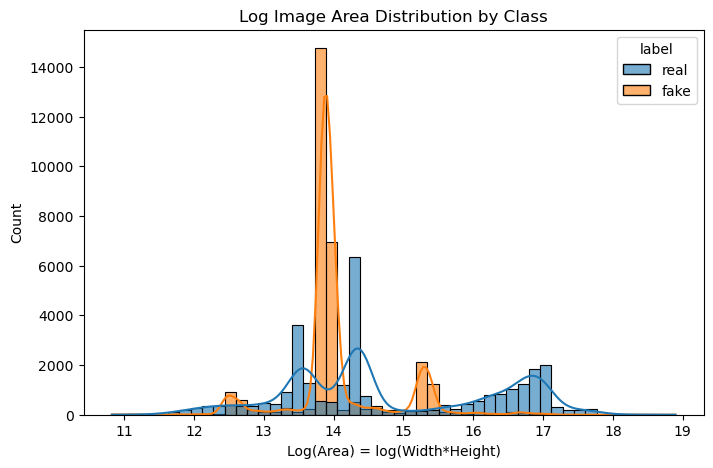

In [47]:
print(df['area'].describe())
plt.figure(figsize=(8,5))
sns.histplot(df,x='log_area',hue='label',bins=50,kde=True,alpha=0.6)
plt.title("Log Image Area Distribution by Class")
plt.xlabel("Log(Area) = log(Width*Height)")
plt.ylabel("Count")
plt.show()

**There is a very large variation in image area, confirmed by the very large standard deviation. Most images, however, are moderate with reasonable sizes for resizing. There is a slightly right-skewed distribution, likely due to a few extremely large images pulling the mean way above the median.**

**Addressing outliers:**

**We need to make a decision about what to do with outliers. First, let's look into the aspect ratio outliers a bit more. We shall use IQR methods to determine outliers.** 

In [49]:
Q1_ar=df['aspect_ratio'].quantile(0.25)
Q3_ar=df['aspect_ratio'].quantile(0.75)
IQR_ar=Q3_ar-Q1_ar

lower_outliers=df[(df['aspect_ratio']<Q1_ar-1.5*IQR_ar)]
print(f"Number of lower aspect ratio outliers: {len(lower_outliers)} ({len(lower_outliers)/len(df)*100:.2f}% of dataset)")

upper_outliers=df[(df['aspect_ratio']>Q3_ar+1.5*IQR_ar)]
print(f"Number of upper aspect ratio outliers: {len(upper_outliers)} ({len(upper_outliers)/len(df)*100:.2f}% of dataset)")

Number of lower aspect ratio outliers: 0 (0.00% of dataset)
Number of upper aspect ratio outliers: 195 (0.33% of dataset)


**Now, let's take a look at area outliers.**

In [48]:
Q1_ar=df['area'].quantile(0.25)
Q3_ar=df['area'].quantile(0.75)
IQR_ar=Q3_ar-Q1_ar

lower_outliers=df[(df['area']<Q1_ar-1.5*IQR_ar)]
print(f"Number of lower area ratio outliers: {len(lower_outliers)} ({len(lower_outliers)/len(df)*100:.2f}% of dataset)")

upper_outliers=df[(df['area']>Q3_ar+1.5*IQR_ar)]
print(f"Number of upper area ratio outliers: {len(upper_outliers)} ({len(upper_outliers)/len(df)*100:.2f}% of dataset)")

Number of lower area ratio outliers: 0 (0.00% of dataset)
Number of upper area ratio outliers: 10375 (17.29% of dataset)


**It's clear that in terms of the asepct ratio, everything seems fine. Most images are close to square, and are safe for resizing and CNN preprocessing. However, there is a noticeable fraction of very large images. These large images will be normalized when resized to 224x224, so they won't break the model, but they may increase preprocessing time. During our data pre-processing we may opt to filter out the largest images if we notice that our preprocessing is taking too much time.**

**As a last EDA step, let's look at correlations. Even though these are images, simple features like width, height, aspect ratio, and area can be correlated.**

                 width    height  aspect_ratio      area
width         1.000000  0.822106      0.267848  0.926451
height        0.822106  1.000000     -0.175558  0.918600
aspect_ratio  0.267848 -0.175558      1.000000  0.052435
area          0.926451  0.918600      0.052435  1.000000


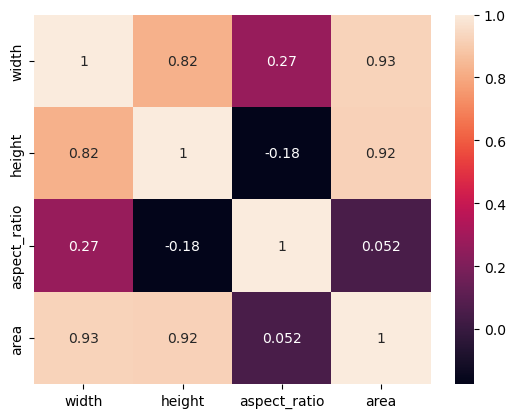

In [51]:
print(df[['width','height','aspect_ratio','area']].corr())
sns.heatmap(df[['width','height','aspect_ratio','area']].corr(),annot=True)
plt.show()

**As expected we have a strong positive correlation between width and height: larger widths usually come with larger heights. It also makes sense that there is a positive correlation of aspect ratio with width and a negative one with height, since aspect_ratio=width/height (width increases -> ratio increases, height increases -> ratio decreases). Area is positively correlated with width and height, which is expected since area=width*height. Finally, area has very weak correlation with aspect ratio, meaning extreme aspect ratios do not dominate area. Generally, the only real conclusion this tells us is that most images are roughly square, area/width/height are largely redundant (carry overlapping information).**

**Finally, let's just take our pick of a few random images from each class for a quick visual peek:** 

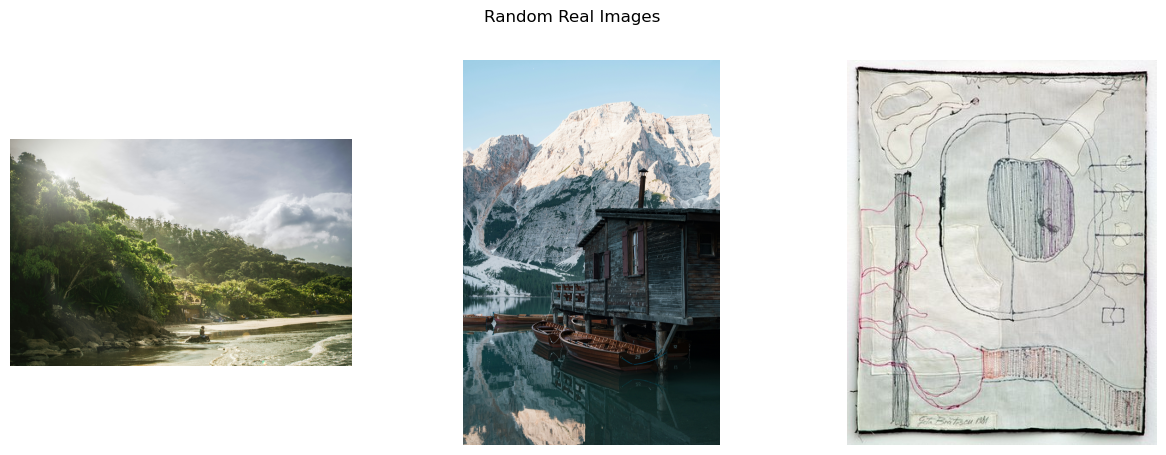

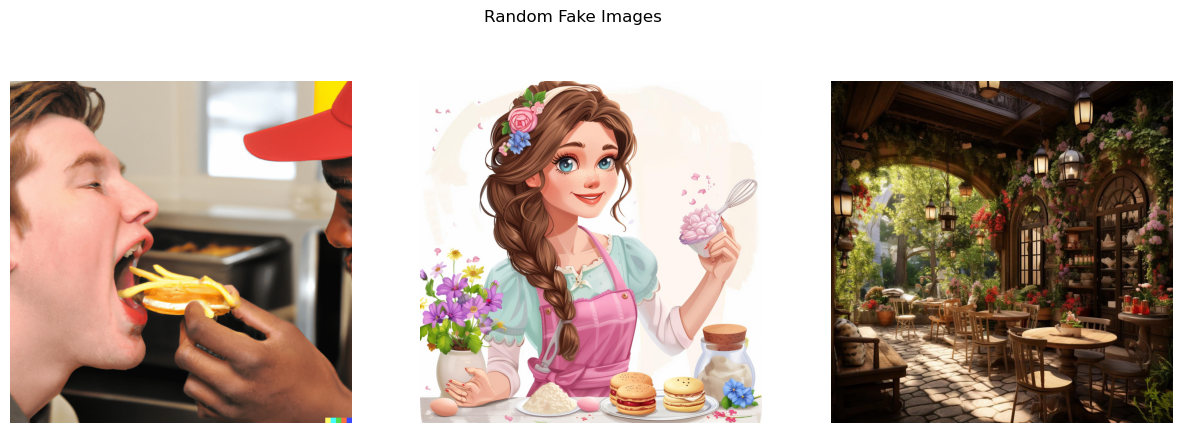

In [55]:
real_samples=df[df['label']=='real']['filepath'].sample(3,random_state=42)
fake_samples=df[df['label']=='fake']['filepath'].sample(3,random_state=42)

plt.figure(figsize=(15,5))
for i,path in enumerate(real_samples):
    img=Image.open(path)
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Random Real Images")
plt.show()

plt.figure(figsize=(15,5))
for i,path in enumerate(fake_samples):
    img=Image.open(path)
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Random Fake Images")
plt.show()

**Some of the above images are quite hard to differentiate between real and fake, this may be a hard task!**